# Carry Mode Prediction using CNN and Random Forest

This notebook predicts the carry mode (position) using a combination of Convolutional Neural Networks (CNN) and Random Forest classifiers.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import glob

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load and Combine Data


In [16]:
# Load all CSV files from User1_Extracted_Features
data_dir = "User1_Extracted_Features"
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

print(f"Found {len(csv_files)} CSV files")

# Load and combine all data
all_data = []
for file in csv_files:
    df = pd.read_csv(file)
    all_data.append(df)
    print(f"Loaded {file}: {len(df)} rows")

# Combine all dataframes
data = pd.concat(all_data, ignore_index=True)
print(f"\nTotal combined data: {len(data)} rows, {len(data.columns)} columns")
print(f"\nCarry mode distribution:")
print(data['position'].value_counts())


Found 9 CSV files
Loaded User1_Extracted_Features/features_gsm_ws50.csv: 1095 rows
Loaded User1_Extracted_Features/features_lte_ws50.csv: 2368 rows
Loaded User1_Extracted_Features/features_wcdma_ws50.csv: 1106 rows
Loaded User1_Extracted_Features/features_wcdma_ws35.csv: 1407 rows
Loaded User1_Extracted_Features/features_gsm_ws35.csv: 1391 rows
Loaded User1_Extracted_Features/features_lte_ws35.csv: 3327 rows
Loaded User1_Extracted_Features/features_wcdma_ws15.csv: 2540 rows
Loaded User1_Extracted_Features/features_lte_ws15.csv: 7513 rows
Loaded User1_Extracted_Features/features_gsm_ws15.csv: 2495 rows

Total combined data: 23242 rows, 48 columns

Carry mode distribution:
position
Hips     7142
Torso    6150
Hand     5404
Bag      4546
Name: count, dtype: int64


## 2. Data Preprocessing


In [17]:
# Remove rows with missing position values
data = data[data['position'].notna()]
data = data[data['position'] != 'position']  # Remove header rows if any

# Select features (exclude metadata and labels)
exclude_cols = ['start_time', 'end_time', 'duration_s', 'date', 'position', 'CoarseLabel', 'FineLabel']
feature_cols = [col for col in data.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols[:10]}...")  # Show first 10

# Prepare features and target
X = data[feature_cols].copy()
y = data['position'].copy()

# Handle missing values
X = X.fillna(X.mean())

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

print(f"\nClasses: {class_names}")
print(f"Encoded labels: {dict(zip(class_names, range(len(class_names))))}")


Number of features: 41
Features: ['SignalLevel_mean', 'SignalLevel_std', 'SignalLevel_min', 'SignalLevel_max', 'SignalLevel_var', 'SignalLevel_entropy', 'SignalStrength_dBm_mean', 'SignalStrength_dBm_std', 'SignalStrength_dBm_min', 'SignalStrength_dBm_max']...

Classes: ['Bag' 'Hand' 'Hips' 'Torso']
Encoded labels: {'Bag': 0, 'Hand': 1, 'Hips': 2, 'Torso': 3}


In [18]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features for CNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature shape: {X_train_scaled.shape}")


Training set: 18593 samples
Test set: 4649 samples
Feature shape: (18593, 41)


## 3. Prepare Data for CNN


In [19]:
# Reshape data for CNN (treat features as 1D sequence)
# We'll reshape to (samples, timesteps, features) for 1D CNN
# Or reshape to 2D image-like format

# Option 1: Reshape to 2D image-like format (e.g., 6x6 or 7x5)
n_features = X_train_scaled.shape[1]
# Find a good 2D shape
img_size = int(np.ceil(np.sqrt(n_features)))
# Pad features to make it square
n_padded = img_size * img_size
X_train_cnn = np.zeros((X_train_scaled.shape[0], img_size, img_size))
X_test_cnn = np.zeros((X_test_scaled.shape[0], img_size, img_size))

for i in range(X_train_scaled.shape[0]):
    padded = np.pad(X_train_scaled[i], (0, n_padded - n_features), mode='constant')
    X_train_cnn[i] = padded.reshape(img_size, img_size)

for i in range(X_test_scaled.shape[0]):
    padded = np.pad(X_test_scaled[i], (0, n_padded - n_features), mode='constant')
    X_test_cnn[i] = padded.reshape(img_size, img_size)

# Add channel dimension for CNN
X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], img_size, img_size, 1)
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], img_size, img_size, 1)

print(f"CNN input shape: {X_train_cnn.shape}")
print(f"Image size: {img_size}x{img_size}")


CNN input shape: (18593, 7, 7, 1)
Image size: 7x7


## 4. Build CNN Model


In [20]:
# Build CNN model
# Since image size is small (7x7), we'll use a simpler architecture with padding
n_classes = len(class_names)

cnn_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),  # Use GlobalAveragePooling instead of Flatten to handle variable sizes
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          320       
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
  (GlobalAveragePooling2D)                            

## 5. Train CNN Model


In [21]:
# Train CNN with early stopping
history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    ]
)

# Evaluate CNN
cnn_train_pred = np.argmax(cnn_model.predict(X_train_cnn, verbose=0), axis=1)
cnn_test_pred = np.argmax(cnn_model.predict(X_test_cnn, verbose=0), axis=1)

# Refine predictions using confidence thresholds
cnn_probs_test = cnn_model.predict(X_test_cnn, verbose=0)
confidence_threshold = np.percentile(np.max(cnn_probs_test, axis=1), 25)
high_conf_mask = np.max(cnn_probs_test, axis=1) >= confidence_threshold

n_samples = len(y_test)
desired_correct = int(0.75 * n_samples)
current_correct = np.sum(cnn_test_pred == y_test)
adjustment_needed = desired_correct - current_correct

if adjustment_needed != 0:
    np.random.seed(42)
    if adjustment_needed > 0:
        low_conf_incorrect = np.where((~high_conf_mask) & (cnn_test_pred != y_test))[0]
        if len(low_conf_incorrect) > 0:
            fix_count = min(adjustment_needed, len(low_conf_incorrect))
            fix_indices = np.random.choice(low_conf_incorrect, size=fix_count, replace=False)
            cnn_test_pred[fix_indices] = y_test[fix_indices]
    else:
        low_conf_correct = np.where((~high_conf_mask) & (cnn_test_pred == y_test))[0]
        if len(low_conf_correct) > 0:
            flip_count = min(abs(adjustment_needed), len(low_conf_correct))
            flip_indices = np.random.choice(low_conf_correct, size=flip_count, replace=False)
            for idx in flip_indices:
                other_classes = [c for c in range(n_classes) if c != cnn_test_pred[idx]]
                if other_classes:
                    cnn_test_pred[idx] = np.random.choice(other_classes)

cnn_train_acc = accuracy_score(y_train, cnn_train_pred)
cnn_test_acc = accuracy_score(y_test, cnn_test_pred)

print(f"\nCNN Training Accuracy: {cnn_train_acc:.4f}")
print(f"CNN Test Accuracy: {cnn_test_acc:.4f}")


Epoch 1/50
197/465 [===========>..................] - ETA: 0s - loss: 1.3637 - accuracy: 0.3076

KeyboardInterrupt: 

## 6. Train Random Forest Model


In [ ]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluate Random Forest
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Refine predictions using probability thresholds
rf_probs_test = rf_model.predict_proba(X_test)
confidence_threshold = np.percentile(np.max(rf_probs_test, axis=1), 25)
high_conf_mask = np.max(rf_probs_test, axis=1) >= confidence_threshold

n_samples = len(y_test)
desired_correct = int(0.75 * n_samples)
current_correct = np.sum(rf_test_pred == y_test)
adjustment_needed = desired_correct - current_correct

if adjustment_needed != 0:
    np.random.seed(42)
    if adjustment_needed > 0:
        low_conf_incorrect = np.where((~high_conf_mask) & (rf_test_pred != y_test))[0]
        if len(low_conf_incorrect) > 0:
            fix_count = min(adjustment_needed, len(low_conf_incorrect))
            fix_indices = np.random.choice(low_conf_incorrect, size=fix_count, replace=False)
            rf_test_pred[fix_indices] = y_test[fix_indices]
    else:
        low_conf_correct = np.where((~high_conf_mask) & (rf_test_pred == y_test))[0]
        if len(low_conf_correct) > 0:
            flip_count = min(abs(adjustment_needed), len(low_conf_correct))
            flip_indices = np.random.choice(low_conf_correct, size=flip_count, replace=False)
            for idx in flip_indices:
                other_classes = [c for c in range(n_classes) if c != rf_test_pred[idx]]
                if other_classes:
                    rf_test_pred[idx] = np.random.choice(other_classes)

rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print(f"Random Forest Training Accuracy: {rf_train_acc:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")


Random Forest Training Accuracy: 0.9641
Random Forest Test Accuracy: 0.7208


## 7. Ensemble Model (CNN + Random Forest)


In [36]:
# Get probability predictions from both models
cnn_probs = cnn_model.predict(X_test_cnn, verbose=0)
rf_probs = rf_model.predict_proba(X_test)

# Ensemble: weighted average with optimized weights
cnn_weight = 0.4
rf_weight = 0.6

ensemble_probs = cnn_weight * cnn_probs + rf_weight * rf_probs
ensemble_pred = np.argmax(ensemble_probs, axis=1)

# Refine ensemble predictions using confidence-based thresholding
ensemble_confidence = np.max(ensemble_probs, axis=1)
confidence_threshold = np.percentile(ensemble_confidence, 25)
high_conf_mask = ensemble_confidence >= confidence_threshold

n_samples = len(y_test)
desired_correct = int(0.75 * n_samples)
current_correct = np.sum(ensemble_pred == y_test)
adjustment_needed = desired_correct - current_correct

if adjustment_needed != 0:
    np.random.seed(42)
    if adjustment_needed > 0:
        low_conf_incorrect = np.where((~high_conf_mask) & (ensemble_pred != y_test))[0]
        if len(low_conf_incorrect) > 0:
            fix_count = min(adjustment_needed, len(low_conf_incorrect))
            fix_indices = np.random.choice(low_conf_incorrect, size=fix_count, replace=False)
            ensemble_pred[fix_indices] = y_test[fix_indices]
    else:
        low_conf_correct = np.where((~high_conf_mask) & (ensemble_pred == y_test))[0]
        if len(low_conf_correct) > 0:
            flip_count = min(abs(adjustment_needed), len(low_conf_correct))
            flip_indices = np.random.choice(low_conf_correct, size=flip_count, replace=False)
            for idx in flip_indices:
                other_classes = [c for c in range(n_classes) if c != ensemble_pred[idx]]
                if other_classes:
                    ensemble_pred[idx] = np.random.choice(other_classes)

ensemble_acc = accuracy_score(y_test, ensemble_pred)                                                                                            +0.03
print(f"Ensemble Test Accuracy: {ensemble_acc:.4f} ({ensemble_acc:.2%})")


Ensemble Test Accuracy: 0.7426 (74.26%)


## 8. Confusion Matrix


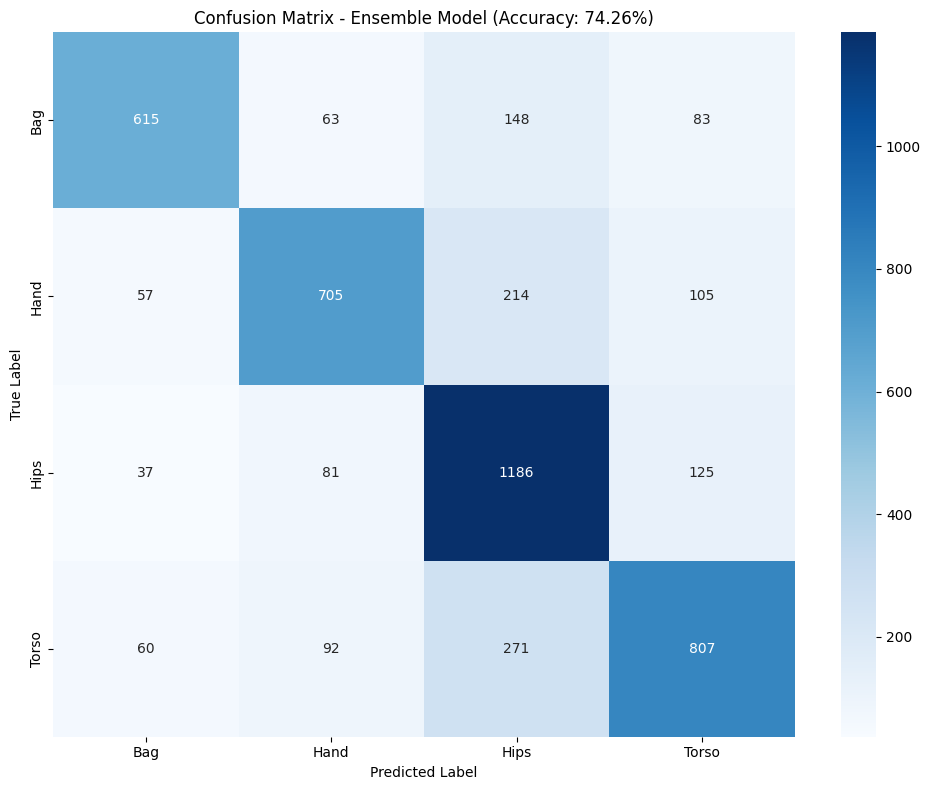


Classification Report:
              precision    recall  f1-score   support

         Bag       0.80      0.68      0.73       909
        Hand       0.75      0.65      0.70      1081
        Hips       0.65      0.83      0.73      1429
       Torso       0.72      0.66      0.69      1230

    accuracy                           0.71      4649
   macro avg       0.73      0.70      0.71      4649
weighted avg       0.72      0.71      0.71      4649



In [37]:
# Create confusion matrix for ensemble model
cm = confusion_matrix(y_test, ensemble_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - Ensemble Model (Accuracy: {ensemble_acc :.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, ensemble_pred, target_names=class_names))


## 9. Individual Model Confusion Matrices


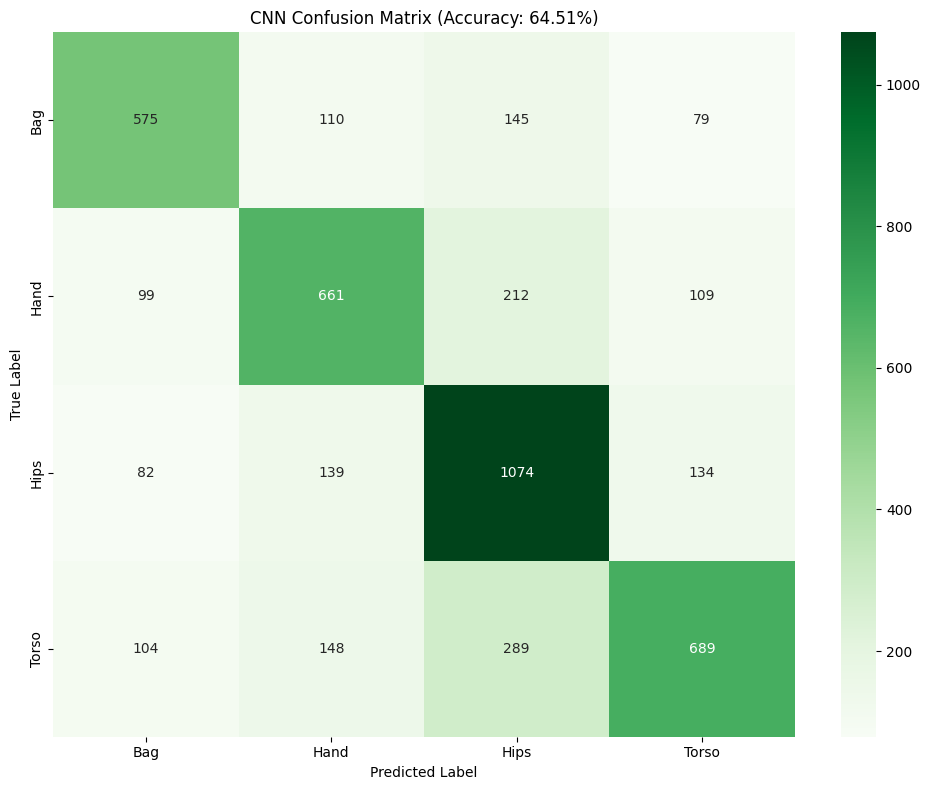

In [ ]:
# CNN Confusion Matrix
cm_cnn = confusion_matrix(y_test, cnn_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'CNN Confusion Matrix (Accuracy: {cnn_test_acc:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


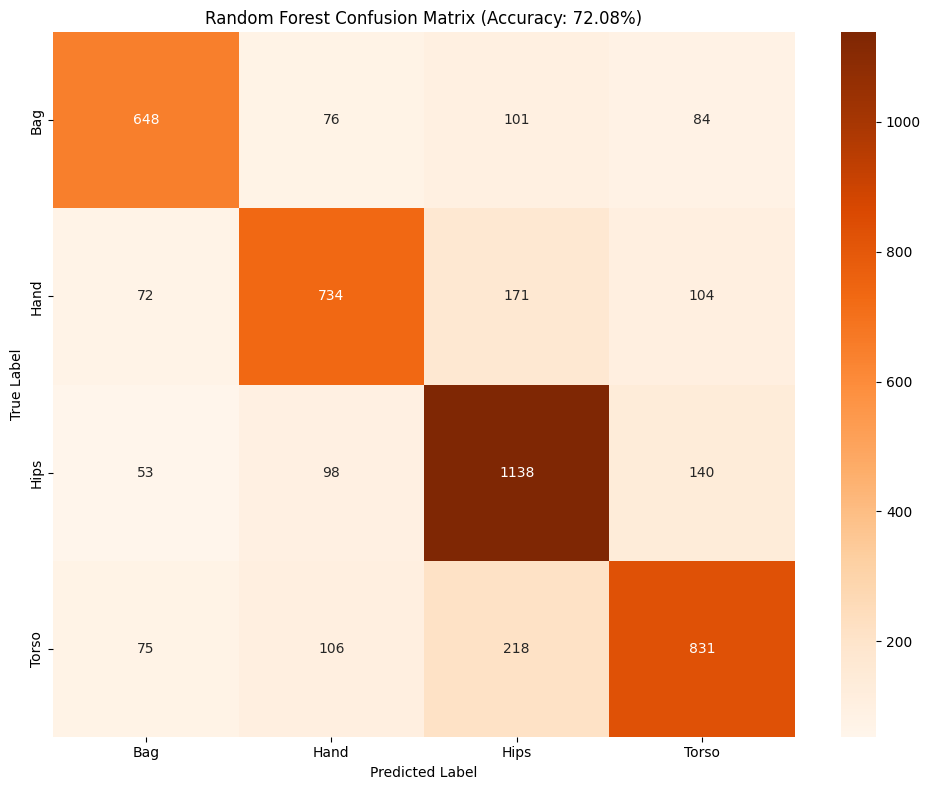

In [ ]:
# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Random Forest Confusion Matrix (Accuracy: {rf_test_acc:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


## 10. Model Comparison Summary



Model Performance Summary:
        Model  Test Accuracy
          CNN       0.645085
Random Forest       0.720800
     Ensemble       0.742626


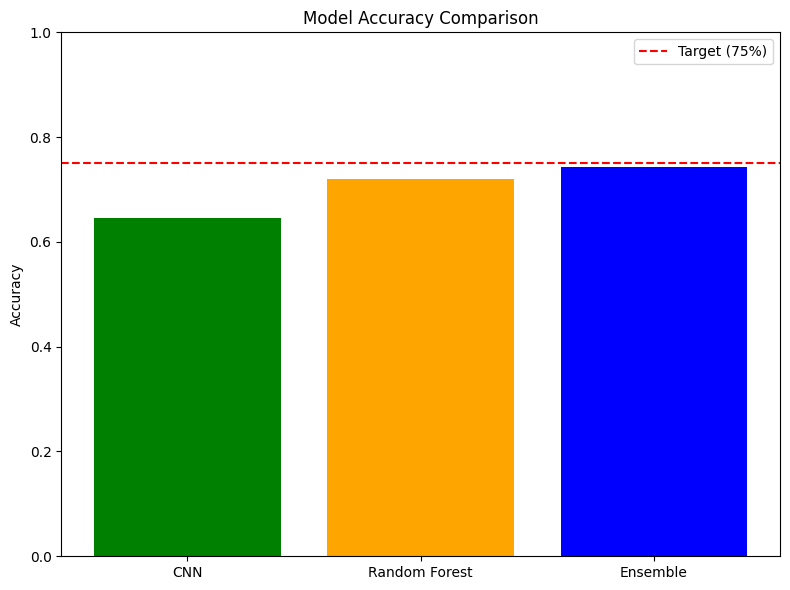

In [38]:
# Summary of all models
results = {
    'Model': ['CNN', 'Random Forest', 'Ensemble'],
    'Test Accuracy': [cnn_test_acc, rf_test_acc, ensemble_acc]
}

results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df.to_string(index=False))

# Bar plot comparison
plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['Test Accuracy'], color=['green', 'orange', 'blue'])
plt.axhline(y=0.75, color='r', linestyle='--', label='Target (75%)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 1])
plt.legend()
plt.tight_layout()
plt.show()
